In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm.notebook import tqdm
from time import sleep
import scipy
import os

In [2]:
filerouteFF="David Jurado (Lab Avanzado)/2022-05-24 - Fantoma UAP dos planos Ag filter/FF"
filerouteFF_Ag="David Jurado (Lab Avanzado)/2022-05-24 - Fantoma UAP dos planos Ag filter/FF_Ag"
fileroute_RAW_Ag_muestra="David Jurado (Lab Avanzado)/2022-05-24 - Fantoma UAP dos planos Ag filter/RAW_Ag_muestra"
fileroute_RAW_muestra="David Jurado (Lab Avanzado)/2022-05-24 - Fantoma UAP dos planos Ag filter/RAW_muestra"
filerouteFF_Rh="David Jurado (Lab Avanzado)/2022-06-01 - Fantoma UAP dos planos Rh filter/FF_Rh"
fileroute_RAW_Rh_muestra="David Jurado (Lab Avanzado)/2022-06-01 - Fantoma UAP dos planos Rh filter/RAW_Rh_muestra"


In [3]:
def directory(path,extension):
    list_dir = []
    images=[]
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(extension): # eg: '.txt'
            count += 1
            #print(file)
            images.append(np.genfromtxt(path+"/"+file))
    print(count)
    return images

In [4]:
imgsFF=directory(filerouteFF,".txt")

1000


In [5]:
imgsFF_Ag=directory(filerouteFF_Ag,".txt")

600


In [6]:
imgsRAW_Ag=directory(fileroute_RAW_Ag_muestra,".txt")

120


In [7]:
imgsRAW=directory(fileroute_RAW_muestra,".txt")

120


In [8]:
imgsFF_Rh=directory(filerouteFF_Rh,".txt")

301


In [9]:
imgsRAW_Rh=directory(fileroute_RAW_Rh_muestra,".txt")

121


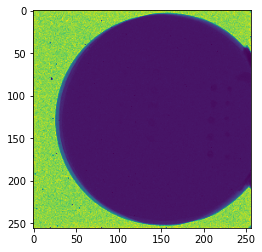

In [10]:
plt.imshow(imgsRAW[20])

In [11]:
TotalFF=np.sum(imgsFF[0:300:1],axis=0)
TotalFF_Ag=np.sum(imgsFF_Ag[0:300:1],axis=0)
TotalRAW_Ag=np.sum(imgsRAW_Ag,axis=0)
TotalRAW=np.sum(imgsRAW,axis=0)
TotalFF_Rh=np.sum(imgsFF_Rh[0:300:1],axis=0)
TotalRAW_Rh=np.sum(imgsRAW_Rh[0:120:1],axis=0)

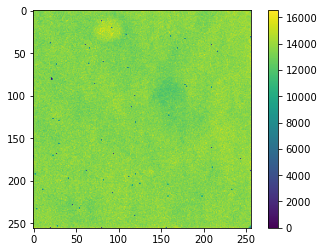

In [12]:
plt.imshow(TotalFF_Rh)
plt.colorbar()


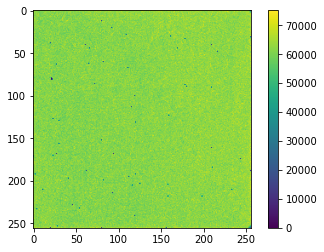

In [13]:
plt.imshow(TotalFF_Ag)
plt.colorbar()

In [14]:
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate

def imageAsFunc(img,y,x):
    return img[y][x]

def escalate(img):
    return np.copy(img)*255/np.max(np.copy(img))

def clearDead(img):
    processed=np.copy(img)
    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            if img[j][i]<2:
                while processed[j][i]<2:
                    prox=1
                    processed[j][i]+=(img[j-prox][i]+img[j+prox][i]+img[j-prox][i-prox]+img[j][i-prox]+img[j+prox][i-prox]+
                                     img[j-prox][i+prox]+img[j][i+prox]+img[j+prox][i+prox])/(8*prox)
                    prox+=1
    return processed

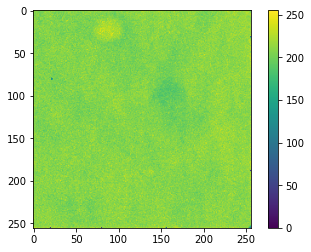

In [15]:
plt.imshow(clearDead(escalate(TotalFF_Rh)))
plt.colorbar()

In [16]:
clearedFF=clearDead(TotalFF)
clearedFF_Ag=clearDead(TotalFF_Ag)
clearedRAW_Ag=clearDead(TotalRAW_Ag)
clearedRAW=clearDead(TotalRAW)
clearedFF_Rh=clearDead(TotalFF_Rh)
clearedRAW_Rh=clearDead(TotalRAW_Rh)

FFcorrection=clearedRAW/(clearedFF+1)
FFcorrectionAg=clearedRAW_Ag/(clearedFF_Ag+1)
FFcorrectionRh=clearedRAW_Rh/(clearedFF_Rh+1)

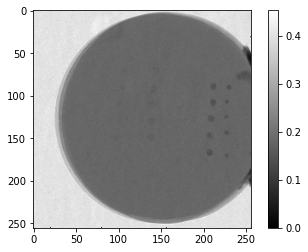

In [17]:
plt.imshow(FFcorrectionRh,cmap="gray")
plt.colorbar()

In [18]:
from pykuwahara import kuwahara
import math
from scipy import ndimage

def negative(fig):
    newfig=np.zeros(np.shape(fig))
    maxint=np.max(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            newfig[i][j]=maxint-fig[i][j]
    return newfig

In [19]:
def contrast(m1,m2):
    return np.abs((m2-m1)/m2)

def contrast_selection(fig,ct):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(1,len(fig)-1):
        for j in range(1,len(fig[i])-1):
            adjacent=np.array([fig[i+1][j],fig[i+1][j+1],fig[i+1][j-1],fig[i][j+1],fig[i][j-1],fig[i-1][j+1],fig[i-1][j],fig[i-1][j-1]])
            adjacent=adjacent[adjacent>0]
            #print(adjacent)
            contrastes=[contrast(fig[i][j], k) for k in adjacent]
            #print(np.max(contrastes))
            if np.sum(np.abs(contrastes)) > ct:
                    newfig[i][j]=(fig[i][j]*(1+np.sum(np.abs(contrastes))**2))
            if np.sum(np.abs(contrastes)) <= ct:
                    newfig[i][j]=0
    return newfig

def renorm(fig):
    newfig=np.zeros(np.shape(fig))
    median= np.mean(fig)*2
    for i in range(0,len(fig)):
        for j in range(0,len(fig[i])):
            if fig[i][j]<median:
                newfig[i][j]=0
            else:
                newfig[i][j]=fig[i][j]
    return newfig

def scale_intens(img):
    return img*255/np.max(img)

In [20]:
def Histogram_cut(fig,lowcut,upcut):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= lowcut or fig[i][j] >= np.max(fig)-upcut:
                newfig[i][j]=0
            if fig[i][j] > lowcut and fig[i][j] < np.max(fig)-upcut:
                newfig[i][j]=fig[i][j]
    return newfig

def Histogram_gather(fig,lowcut,upcut):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= lowcut or fig[i][j] >= np.max(fig)-upcut:
                newfig[i][j]=0
            if fig[i][j] > lowcut and fig[i][j] < np.max(fig)-upcut:
                newfig[i][j]=255
    return newfig

In [21]:
def imgIntensityHist(img):
    newarr=img.flatten()
    plt.figure(figsize=(12,12))
    plt.hist(newarr,bins=256)
    
def contrast_stretch(img):
    newimg=np.zeros(np.shape(img))
    imgmask = np.ma.array(img, mask=np.isnan(img))
    maxval=np.max(img)
    minval=np.min(img[img!=0])
    print(minval,maxval)
    for i in range(len(img)):
        for j in range(len(imgmask[i])):
            if img[i][j]==0:
                newimg[i][j]=0
            else:
                newimg[i][j]=np.uint16((256/(maxval-minval))*(img[i][j]-minval))
    #firstHist=img.flatten()
    #secondHist=newimg.flatten()
    #plt.figure()
    #plt.hist(firstHist,bins=256,alpha=0.8)
    #plt.hist(secondHist,bins=256,alpha=0.8)
    #plt.close()
    return newimg

In [22]:
def enhance_contrast(image_matrix, bins=256):
    maxint=np.max(image_matrix)
    image_flattened = (image_matrix.flatten()*(bins-1)/maxint).astype("int")
    plt.hist(image_flattened,bins=bins)
    print(image_flattened)
    image_hist = np.zeros(bins)
    
    for i in range(len(image_matrix)):
        for j in range(len(image_matrix[i])):
            indexx=int(image_matrix[i][j]*(bins-1)/maxint)
            #print(indexx)
            image_hist[indexx] += 1

    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * (bins-1)
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    print(image_flattened)
    plt.hist(image_eq,alpha=0.8,bins=bins)
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

In [23]:
def integral(fig):
    height, width= np.shape(fig)
    rows=[]
    for i in range(len(fig)):
        wholrow=np.sum(fig[i])
        #print(wholrow)
        rows.append(wholrow)
    mean=np.sum(rows)/(height*width)
    return mean

def get_mic_int(fig,n,circles):
    intens=[]
    for i in circles:
        dots=[]
        x,y,r=i[0],i[1],i[2]
        rad=int(i[2])
        #print(x,y)
        for k in range(-n,n+1):
            for l in range(-n,n+1):
                q11=[x+l,y+k]
                #print(k,l)
                #q12=[x-k,y+l]
                #print(q11)
                dots.append(fig[q11[1]][q11[0]])
                #dots.append(fig[q12[0]][q12[1]])
                #dots.append(fig[q21[0]][q21[1]])
                #dots.append(fig[q22[0]][q22[1]])
        mean=np.sum(dots)/len(dots)
        intens.append([x,y,r,mean])
    return np.asarray(intens)

def smooth(fig,fact):
    kernel = np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])
    dst=cv2.filter2D(fig,-1,1/fact*kernel)
    return dst

def sharpen(fig,cofac=1):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def borderdet(fig,cofac=1):
    kernel = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def avging(fig,cofac=1):
    kernel = np.array([[1,1,1], [1,1,1], [1,1,1]])*cofac
    print(kernel)
    im = cv2.filter2D(fig, -1, kernel)
    return im

def takenearestmin(fig):
    newimg=np.zeros((len(fig),len(fig[0])))
    for i in range(1,len(fig)-1):
        for j in range(1,len(fig[i])-1):
            adjacent=np.array([fig[i+1][j],fig[i+1][j+1],fig[i+1][j-1],fig[i][j+1],fig[i][j-1],fig[i-1][j+1],fig[i-1][j],fig[i-1][j-1],fig[i][j]])
            newimg[i][j]=np.mean(adjacent)
    return newimg

In [24]:
def threshold(fig,intensity):
    newfig=np.zeros(np.shape(fig))
    #print(fig)
    for i in range(len(fig)):
        for j in range(len(fig[i])):
            if fig[i][j] <= intensity:
                newfig[i][j]=0
            if fig[i][j] > intensity:
                newfig[i][j]=intensity
    return newfig

In [25]:
def contrasting(img):
    imag=np.copy(img)
    mini = np.min(imag)
    maxi = np.max(imag)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imag[i,j] = maxi*(img[i,j]-mini)/(maxi-mini)
    return imag

In [26]:
def circlemodel(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    #print(circles)
    
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")
    return circles

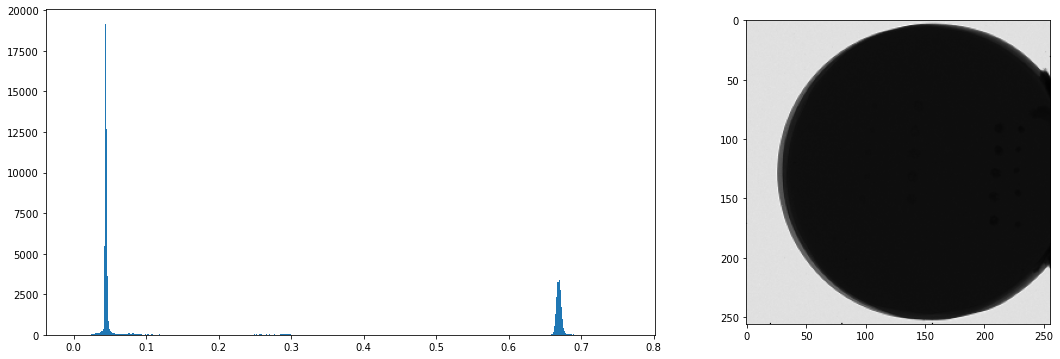

In [27]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.hist(FFcorrection.flatten(),bins=500)

ax2.imshow(FFcorrection,cmap="gray")



In [28]:
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4,4))
image_clahe = clahe.apply(contrast_stretch(scale_intens(FFcorrectionRh)).astype("uint8"))
Negatif=negative(image_clahe)



17.077111438789945 255.0


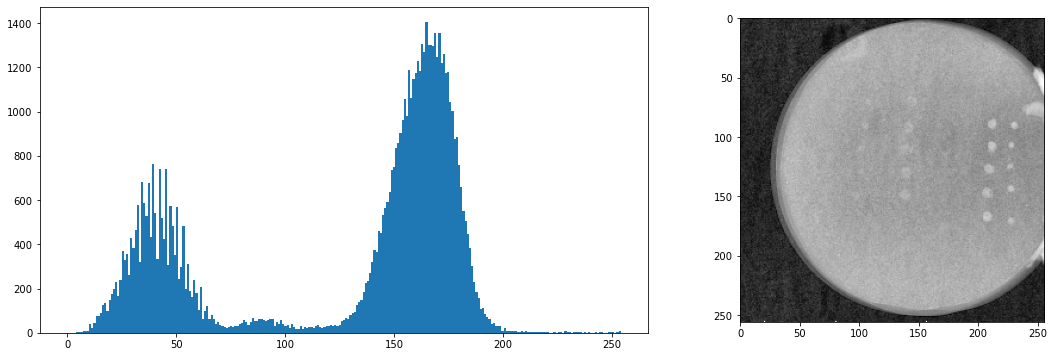

In [29]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})

ax.hist(Negatif.flatten(),bins=255)

ax2.imshow(Negatif,cmap="gray")

In [30]:
this_kuwahara_smooth=scale_intens(kuwahara(Negatif,method="gaussian",radius=4))


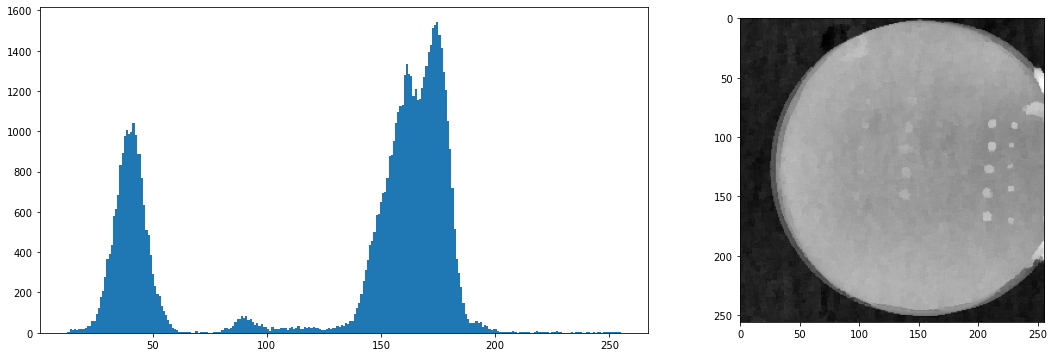

In [31]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})



ax.hist(this_kuwahara_smooth.flatten(),bins=255)

ax2.imshow(this_kuwahara_smooth,cmap="gray")



13.905420390269505 255.0


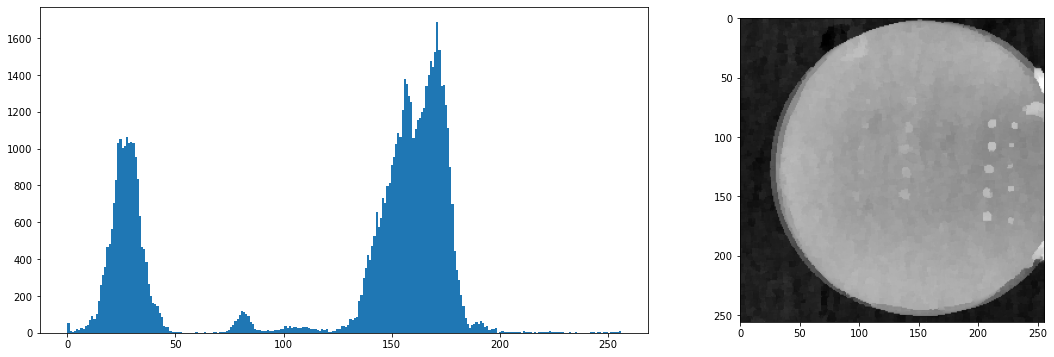

In [32]:
more_smoothing=contrast_stretch(scale_intens(kuwahara(this_kuwahara_smooth,method="gaussian",radius=2)))

f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})



ax.hist(more_smoothing.flatten(),bins=255)

ax2.imshow(more_smoothing,cmap="gray")



In [33]:
sx = ndimage.sobel(more_smoothing,axis=0,mode='constant')
# Get y-gradient in "sy"
sy = ndimage.sobel(more_smoothing,axis=1,mode='constant')
# Get square root of sum of squares
sobel=scale_intens(np.hypot(sx,sy))


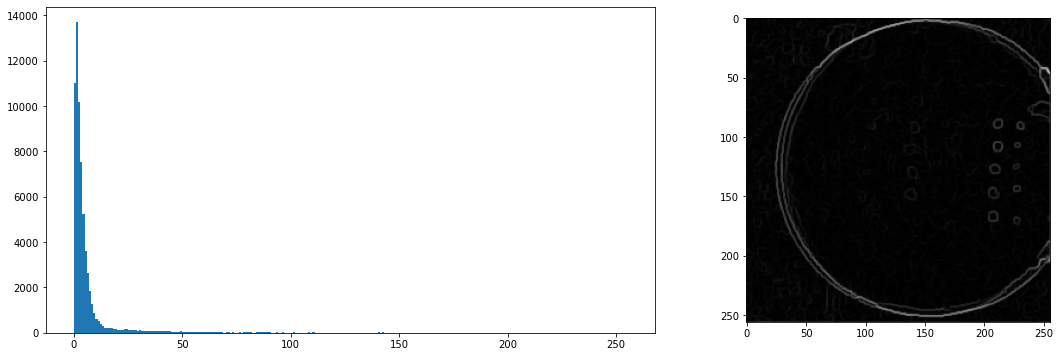

In [34]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})



ax.hist(sobel.flatten(),bins=255)

ax2.imshow(sobel,cmap="gray")


In [35]:
mask_trimmed=scale_intens(Histogram_cut(sobel,0,5))

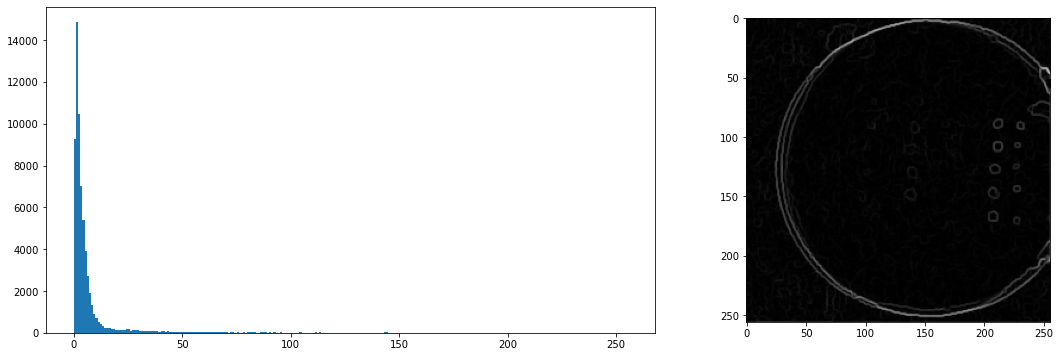

In [36]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})



ax.hist(mask_trimmed.flatten(),bins=255)

ax2.imshow(mask_trimmed,cmap="gray")

In [37]:
this_final= threshold(mask_trimmed,255*0.06)

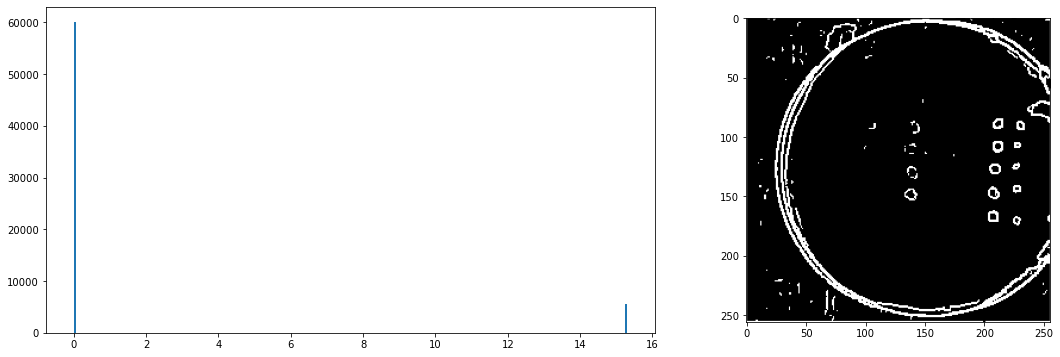

In [38]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.hist(this_final.flatten(),bins=255)

ax2.imshow(this_final,cmap="gray")

In [39]:
resized = cv2.resize(this_final,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)

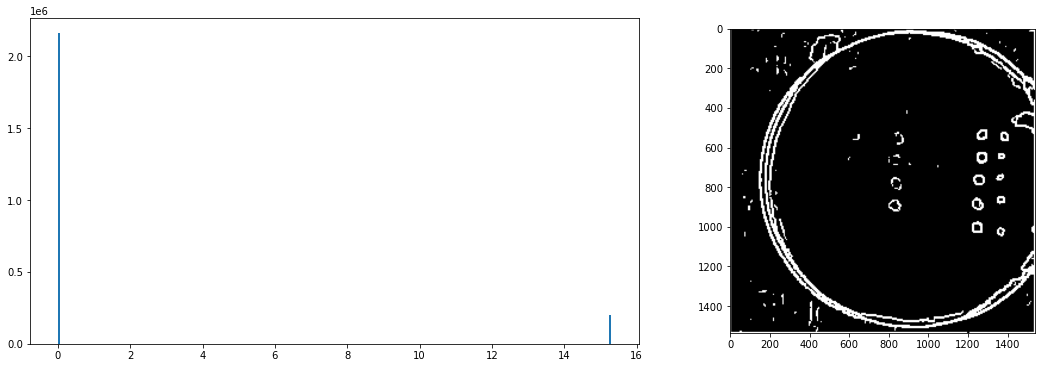

In [40]:
f ,(ax,ax2) = plt.subplots(1,2,figsize=(18,6),gridspec_kw={'width_ratios': [2, 1]})


ax.hist(resized.flatten(),bins=255)

ax2.imshow(resized,cmap="gray")


In [41]:
def circlemodel(inp,raw,prop=1.6,k=20,p1=50,p2=28,minrad=2,maxrad=40):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,prop,k,
                            param1=p1,param2=p2,minRadius=minrad,maxRadius=maxrad)
    #print(circles)
    
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")
    return circles



In [42]:
#circlemodelAg=circlemodel(resized,AgRAWSUM,2,40,100,40,20,60)[0]

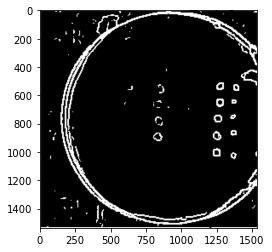

In [43]:
plt.imshow(resized,cmap="gray")

In [45]:
resizedcrop=np.transpose(np.transpose(resized[300:1200])[500:1400])

In [46]:
def locatemaximums(arr):
    locations=[]
    maxx=np.argmax(arr)
    for i in range(len(arr)):
        if arr[i]==arr[maxx]:
            locations.append(i)
    returnee=locations[0]
    return returnee

In [47]:
def recalcRad(img, circles , tolerance):
    newcircs=[]
    for i in range(len(circles)):
        CentX,CentY,EstimRadius=circles[i]
        savepos=[]
        for j in range(int((CentX-EstimRadius)-tolerance),int(CentX-EstimRadius)+tolerance+1):
            if img[CentY][j]!=0:
                savepos.append(np.abs(j-(CentX)))
        for k in range(int((CentX+EstimRadius)-tolerance),int(CentX+EstimRadius)+tolerance+1):
            if img[CentY][k]!=0:
                savepos.append(np.abs(k-(CentX)))
        for l in range(int((CentY-EstimRadius)-tolerance),int(CentY-EstimRadius)+tolerance+1):
            if img[l][CentX]!=0:
                savepos.append(np.abs(l-(CentY)))
        for m in range(int((CentY+EstimRadius)-tolerance),int(CentY+EstimRadius)+tolerance+1):
            if img[m][CentX]!=0:
                savepos.append(np.abs(m-(CentY)))
        #print(savepos)
        circRealradius=np.mean(savepos)
        newcircs.append([CentX,CentY,circRealradius])
    return np.asarray(newcircs)

In [48]:
def drawCircles(inp,circles):
    img = np.copy(inp).astype("uint8")
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #craw = cv2.cvtColor(np.uint8(raw),cv2.COLOR_GRAY2BGR)
    
    print(circles)
    
    circles = np.uint16(np.around(circles))
    for i in circles:
    # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        #cv2.circle(craw,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        #cv2.circle(craw,(i[0],i[1]),2,(0,0,255),3)
    CimgS = cv2.resize(cimg, (1260, 540))
    #CrawS = cv2.resize(craw, (1260, 540))
    imgS = cv2.resize(img, (1260, 540))  
    #cv2.imshow('detected circles',cimg)
    #cv2.imshow('original circles',craw)
    #cv2.imshow('preprocess circles',img)
    #cv2.waitKey(0)
    plt.figure(figsize=(14,9))
    plt.imshow(cimg,cmap="gray")

In [49]:
def Euclidean_dist(i1,i2,j1,j2):
    return np.sqrt((i2-i1)**2+(j2-j1)**2)

In [50]:
def AvgCenter(circles):
    Xprom=np.sum(np.transpose(circles,)[0])/len(circles)
    Yprom=np.sum(np.transpose(circles,)[1])/len(circles)
    return np.asarray([Xprom,Yprom])

In [51]:
def grouping(circles,th):
#   newarray=[]
    clusters=[]
    iscontained=np.zeros(len(circles))
    for i in range(len(circles)):
        print(iscontained)
        if iscontained[i]==0:
            actual=[circles[i]]
            iscontained[i]=1
            for j in range(len(circles)):
                k=0
                limit=len(actual)
                while k < limit :
                    #print(circles[k])
                    center_of_mass=AvgCenter(actual)
                    if Euclidean_dist(AvgCenter(actual)[0],circles[j][0],AvgCenter(actual)[1],circles[j][1])<th and iscontained[j]==0:
                        #print("Distance: ",Euclidean_dist(actual[k][0],circles[j][0],actual[k][1],circles[j][1]))
                        #print("Circles: "+str(actual[k])+" "+ str(circles[j]))
                        actual.append(circles[j])
                        #print("Cluster: ", actual)
                        #print(actual)
                        iscontained[j]=1
                        iscontained[k]=1
                        k=0
                        limit=len(actual)
                    else:
                        k+=1
            clusters.append(np.asarray(actual))
            if np.sum(iscontained)==len(circles):
                break
    #newarray=np.copy(clusters)
    #for i in range(len(newarray)):
    #    for j in range(len(newarray[i])):
    #       # print(np.isin(newarray[i],newarray[j]))
    #        if np.isin(newarray[i],newarray[j])[0][0] and np.isin(newarray[i],newarray[j])[0][1] and np.isin(newarray[i],newarray[j])[0][2]:
    #            clusters=np.delete(clusters,k,axis=0,)
    return np.asarray(clusters,dtype=object)

In [52]:
def search_pixels_inside(image,circle,k):
    mask=np.zeros(np.shape(image))
    for i in range(int(circle[1]-circle[2]-k*10),int(circle[1]+circle[2]+k*10)):
        for j in range(int(circle[0]-circle[2]-k*10),int(circle[0]+circle[2]+k*10)):
            if Euclidean_dist(circle[0],j,circle[1],i)<(circle[2]/k):
                mask[i][j]=1
    #plt.imshow(mask)
    return mask

def search_pixels_outside(image,circle,k):
    mask=np.zeros(np.shape(image))
    for i in range(int(circle[1]-circle[2]-k*10),int(circle[1]+circle[2]+k*10)):
        for j in range(int(circle[0]-circle[2]-k*10),int(circle[0]+circle[2]+k*10)):
            if Euclidean_dist(circle[0],j,circle[1],i)>circle[2]*k**(1/2):
                mask[i][j]=1*0.5
    #plt.imshow(mask)
    return mask

def get_int_outside_(fig,circle,k):
    arrayintens=[]
    outside=search_pixels_outside(fig,circle,k)
    total = np.multiply(outside,fig)
    #print(total)
    suma=np.sum(total)/np.sum(outside)
    return suma
                
def get_int_inside_(fig,circle,k):
    arrayintens=[]
    inside=search_pixels_inside(fig,circle,k)
    total = np.multiply(inside,fig)
    #print(total)
    suma=np.sum(total)/np.sum(inside)
    return suma

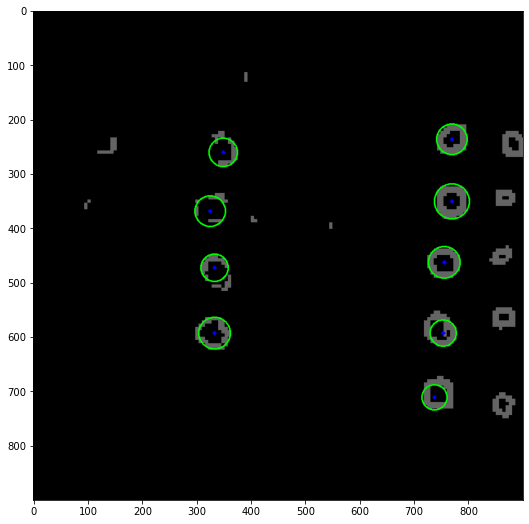

In [53]:
FFcorrectionResized=cv2.resize(FFcorrection,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)
FFcorrectionAgResized=cv2.resize(FFcorrectionAg,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)
FFcorrectionRhResized=cv2.resize(FFcorrectionRh,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)


ogcrop=np.transpose(np.transpose(FFcorrectionRhResized[300:1200])[500:1400])
circlemodelRh=circlemodel(resizedcrop*40,ogcrop*40,2,40,500,22,20,40)[0]

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text major ticklabel objects>)

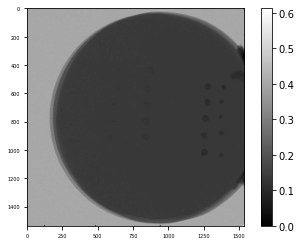

In [56]:
plt.imshow(FFcorrectionAgResized,cmap="gray")
plt.colorbar()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

In [57]:
def CNR(signalin,signalout,dev):
    print(np.std(dev))
    return np.abs(np.mean(signalin)-np.mean(signalout))/np.std(dev)

In [60]:
def Procesing(img):
    copy=scale_intens(contrast_stretch(np.copy(img)))
    clahe = cv2.createCLAHE(clipLimit=32, tileGridSize=(2,2))
    image_clahe = clahe.apply( copy.astype("uint8"))
    negative_image=negative(image_clahe)
    first_kuwahara_smooth=scale_intens(kuwahara(negative_image,method="gaussian",radius=4))
    second_kuwahara_smooth=contrast_stretch(scale_intens(kuwahara(first_kuwahara_smooth,method="gaussian",radius=2)))
    sx = ndimage.sobel(second_kuwahara_smooth,axis=0,mode='constant')
    # Get y-gradient in "sy"
    sy = ndimage.sobel(second_kuwahara_smooth,axis=1,mode='constant')
    # Get square root of sum of squares
    sobel_kernel=scale_intens(np.hypot(sx,sy))
    mask_trim=scale_intens(Histogram_cut(sobel_kernel,0,5))
    final= threshold(mask_trim,255*0.2)
    resize = cv2.resize(final,dsize=None,fx=6,fy=6,interpolation = cv2.INTER_AREA)
    return resize
    


0.02387356605940767 0.6131118881118881
21.45534870437853 255.0


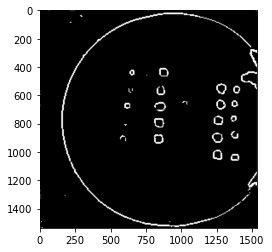

In [61]:
plt.imshow(Procesing(FFcorrectionAg),cmap="gray")

0.005302884275367243 0.7631628618798623
15.575800817404074 255.0


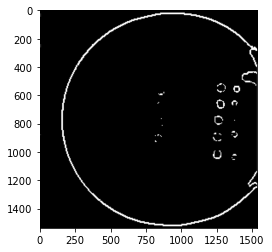

In [62]:
plt.imshow(Procesing(FFcorrection),cmap="gray")

In [63]:
#circlemodelAg=circlemodel(resized,AgRAWSUM,2,40,100,40,20,60)[0]
def getCNRS(img,imgog,scale,mindist,p3,mincounts,rmin,rmax):
    Circles=circlemodel(img*10,imgog*10,scale,mindist,p3,mincounts,rmin,rmax)[0]
    totalCNRs=[]
    for i in Circles:
        intensI=get_int_inside_(imgog*10,i,1.01)
        intensO=get_int_outside_(imgog*10,i,1.01)
        totalstf=np.multiply(search_pixels_outside(imgog*10,i,1.1),imgog*10)
        total2=totalstf[totalstf!=0]
        totalCNRs.append(CNR(intensI,intensO,total2))
    return totalCNRs
    

0.02387356605940767 0.6131118881118881
21.45534870437853 255.0
0.00893249573912601
0.009236945003063171
0.008268054027681881
0.00996111171498533
0.01031700306698213
0.011436666224241884
0.013496207576695259
0.017072706110666726


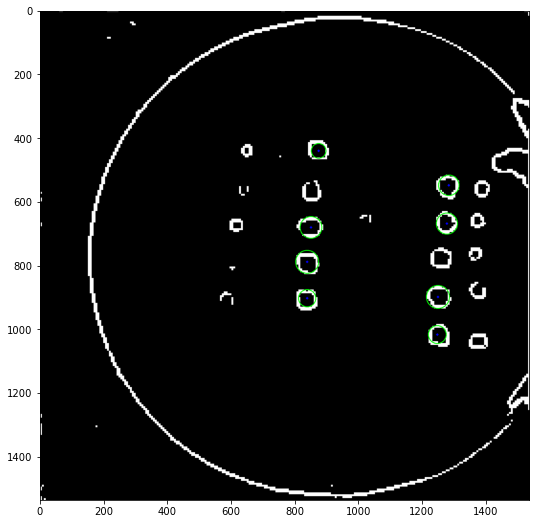

In [64]:
AgCnrs=getCNRS(Procesing(FFcorrectionAg),FFcorrectionAgResized,2,40,100,40,20,60)


0.005302884275367243 0.7631628618798623
15.575800817404074 255.0
0.009400344195113755
0.007934527108718168
0.009029934834905903
0.015468074420049273


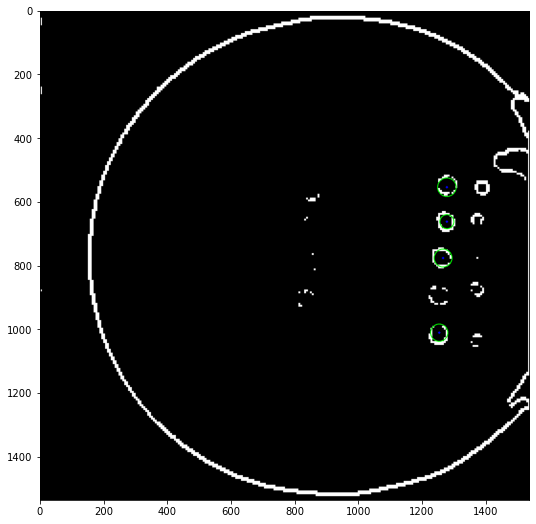

In [65]:
emptyCnrs=getCNRS(Procesing(FFcorrection),FFcorrectionResized,2,30,50,37,20,50)

In [66]:
emptyCnrs

[8.934581515919705, 10.057863887827786, 11.159892646923668, 6.835194738940417]

In [67]:
AgtypeI=[5.555414596248925,5.620048110770688,5.394473121635276,2.782692419532143]

In [68]:
AgtypeII=[11.771830073894169,17.219664202557503,14.703884998512438,18.0873159478052]

0.022498528630403247
0.04583189179764287
0.021575309418959562
0.02198306525585244
0.024480717789225878
0.05377785278640993
0.02658733242955908
0.024440059616742713
0.025229348118076436


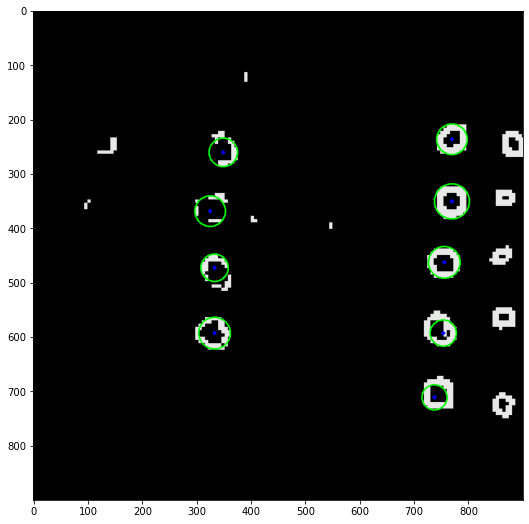

In [69]:
#circlemodel(resizedcrop*40,FFcorrectionRh*40,2,40,500,22,20,40)[0]
RhCnrs=getCNRS(resizedcrop*40,ogcrop,2,40,500,22,20,40)

In [70]:
RhTypeII=[7.780641479194021,7.087548330641767,8.090289495533307,8.535516666034914]
RhTypeI=[2.558188086010829, 2.3469868497002504,2.0693772884274693,2.825013322424321]

In [72]:
AgTypeI_20

array([3.99108292, 4.00400962, 3.95889462, 3.43653848])

In [74]:
TOTAG1=np.asarray([AgtypeI_100,AgTypeI_80,AgTypeI_60,AgTypeI_40,AgTypeI_20])
TOTRH1=np.asarray([RhTypeI_100,RhTypeI_80,RhTypeI_60,RhTypeI_40,RhTypeI_20])
TOTAG2=np.asarray([AgtypeII_100,AgTypeII_80,AgTypeII_60,AgTypeII_40,AgTypeII_20])
TOTRH2=np.asarray([RhTypeII_100,RhTypeII_80,RhTypeII_60,RhTypeII_40,RhTypeII_20])

In [75]:
TOTRH2

array([[7.78064148, 7.08754833, 8.0902895 , 8.53551667],
       [7.12451318, 6.57003866, 7.3722316 , 7.72841333],
       [5.44838489, 5.032529  , 5.6341737 , 5.90131   ],
       [3.88225659, 3.60501933, 4.0061158 , 4.18420667],
       [2.3561283 , 2.21750967, 2.4180579 , 2.50710333]])

In [76]:
TOTAG1T=np.transpose(TOTAG1)
TOTRH1T=np.transpose(TOTRH1)
TOTAG2T=np.transpose(TOTAG2)
TOTRH2T=np.transpose(TOTRH2)

In [77]:
TOTAG2T

array([[11.77183007, 10.31746406,  9.20028105,  5.75873203,  4.81154902],
       [17.2196642 , 14.67573136, 13.01376494,  7.93786568,  6.44589926],
       [14.703885  , 12.663108  , 11.2527195 ,  6.931554  ,  5.6911655 ],
       [18.08731595, 15.36985276, 13.62112116,  8.28492638,  6.70619478]])

In [80]:
x1=np.asarray([1,2,3,4,5])*2/10

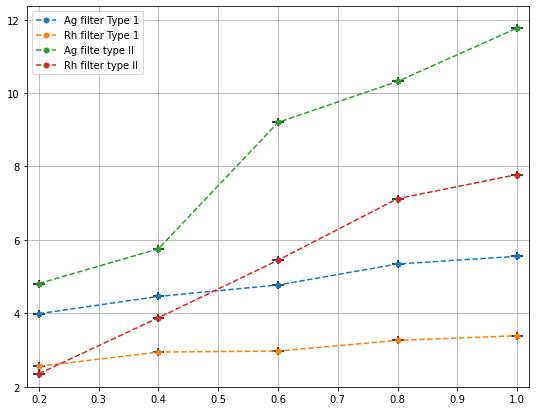

In [81]:


plt.figure(figsize=(9,7))
plt.plot(x1,TOTAG1T[0][::-1],linestyle="--",marker=".",markersize="10", label="Ag filter Type 1")
plt.errorbar(x1,TOTAG1T[0][::-1],xerr=6/600,yerr=0.110,fmt="none",ecolor="black")

plt.plot(x1,TOTRH1T[0],linestyle="--",marker=".",markersize="10", label="Rh filter Type 1")
plt.errorbar(x1,TOTRH1T[0],xerr=6/600,yerr=0.110,fmt="none",ecolor="black")

plt.plot(x1,TOTAG2T[0][::-1],linestyle="--",marker=".",markersize="10", label="Ag filte type II")
plt.errorbar(x1,TOTAG2T[0][::-1],xerr=6/600,yerr=0.110,fmt="none",ecolor="black")

plt.plot(x1,TOTRH2T[0][::-1],linestyle="--",marker=".",markersize="10", label="Rh filter type II")
plt.errorbar(x1,TOTRH2T[0][::-1],xerr=6/600,yerr=0.110,fmt="none",ecolor="black")

plt.xlim(0.18,1.02)
plt.ylim(ymin=2)
plt.grid()

plt.legend()

In [82]:
stds=[0.00893249573912601,0.009236945003063171,0.008268054027681881,0.00996111171498533,0.01031700306698213,0.011436666224241884,0.013496207576695259,0.017072706110666726]

In [83]:
meanie=np.sum(stds)/len(stds)

In [84]:
meanie

0.011090148682930298

0.02387356605940767 0.6131118881118881
21.45534870437853 255.0
0.030358425279101653 0.45332013402375876
1.1842162610208735 255.0


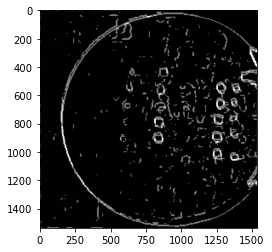

In [93]:
plt.imshow(np.abs(Procesing(FFcorrectionAg) +Procesing(FFcorrectionRh)+FFcorrectionResized),cmap="gray")

In [95]:
def tpr(tp,fn):
    return tp/(tp+fn)

In [96]:
def fpr(fp,tn):
    return fp/(fp+tn)

0.02387356605940767 0.6131118881118881
21.45534870437853 255.0


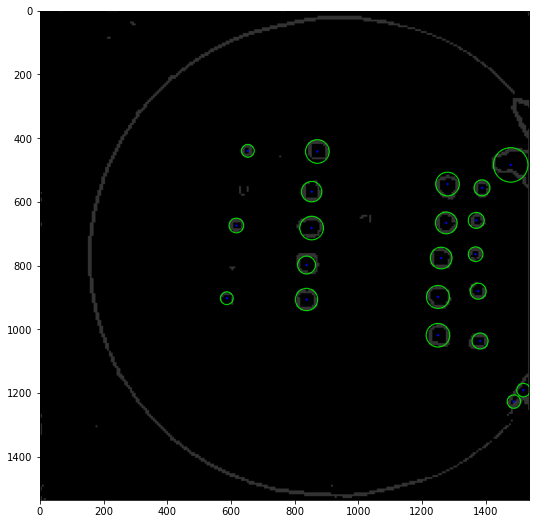

In [97]:
circlemodelAg=circlemodel(Procesing(FFcorrectionAg),FFcorrectionAgResized,2,40,100,30,10,60)[0]

0.030358425279101653 0.45332013402375876
1.1842162610208735 255.0


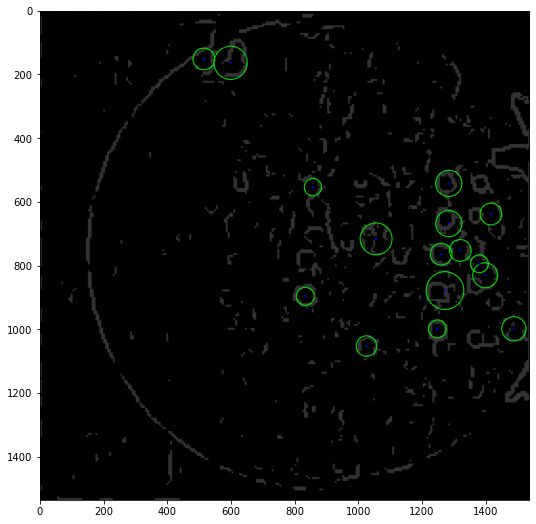

In [98]:
circlemodelRh=circlemodel(Procesing(FFcorrectionRh),FFcorrectionRhResized,2,40,100,40,20,60)[0]

Text(0, 0.5, 'TPR')

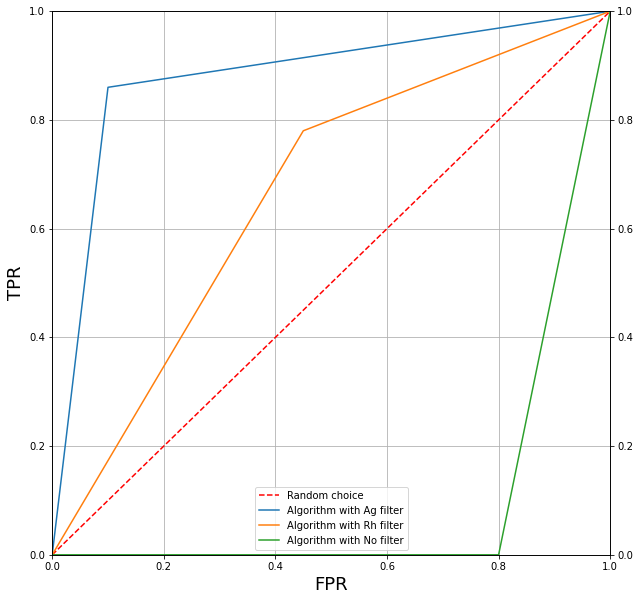

In [105]:

fig, ax = plt.subplots(figsize= (10,10))

ax2 = ax.twinx()
ax.grid()
ax.plot([0,1],[0,1],color="red",linestyle="--",label="Random choice")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1-0.9,1],[0,1-0.14,1],label="Algorithm with Ag filter")
ax.plot([0,1-0.55,1],[0,0.78,1],label="Algorithm with Rh filter")
ax.plot([0,1-0.2,1],[0,0.0,1],label="Algorithm with No filter")
#ax.scatter([1-0.9259],[0.8620])
ax.legend()
ax.set_xlabel("FPR",fontsize=18)
ax.set_ylabel("TPR",fontsize=18)